# Imports

In [1]:
import fiona
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import shapely 
from shapely import Polygon, MultiPolygon 
import rasterio
from rasterio.warp import transform_geom
from typing import List

In [2]:
from data.config import CONFIG
from utilities.area import EARTH_RADIUS, get_density_per_area
from utilities.geojson import (
    filter_features, filter_features_by_list, filter_features_by_bounds, filter_features_by_proximity, 
    get_polygons,
    convert_dict_to_shapely,
)
from utilities.plotting import plot_polygon, plot_polygons

In [3]:
data_dir = r'../../datasets/geospatial'

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

https://data.metabolismofcities.org/dashboards/johannesburg/hub/harvesting/852/

Johannesburg, South Africa

In [4]:
coj_path = os.path.join(data_dir, "borders", "2018_Regions_CoJ/2018_Regions.shp")
city_of_joburg_data = fiona.open(coj_path, "r")
polygons = get_polygons(city_of_joburg_data, identifier='REGION_NAM')
city_of_joburg_projected = transform_geom(
    city_of_joburg_data.crs,
    rasterio.crs.CRS.from_epsg(4326),
    polygons.values()
)
city_of_joburg_polygons = dict(
    (name, Polygon(geom['coordinates'][0])) for name, geom in zip(polygons.keys(), city_of_joburg_projected)
)
sa_raster_filepath = 'zaf_ppp_2020_constrained.tif'

## Functions

<b>Method1</b>

Rough scale correction

$$
\begin{align}
    y &= R\phi \\
    x &= R\lambda \cos(\phi)
\end{align}
$$

In [5]:
def scale_correction(polygons: dict):
    long_min, lat_min, long_max, lat_max = bounds(list(polygons.values()))
    lat_avg = (lat_max + lat_min) / 2
    long_avg = (long_min + long_max) / 2
    scale = np.cos(np.deg2rad(lat_avg))
    polygons_out = dict()
    origin = np.array((long_avg, lat_avg))
    for name, polygon in polygons.items():
        coords = polygon.exterior.coords - origin
        coords[:, 0] *= scale
        polygons_out[name] = Polygon(coords)
    return polygons_out

<b>Method 2</b>

Correct with locally centered transverse Mercators. See http://pygis.io/docs/d_understand_crs_codes.html.

In [6]:
def transverse_mercator_projection(polygons: dict, long: float):
    dst_src = {
        'proj': 'tmerc',
        'lat_0': 0,
        'lon_0': long,
        'k': 1/1000, # convert to km
        'x_0': 0,
        'y_0': 0,
        'ellps': 'WGS84',
        'units': 'm',
        'no_defs': True
    }
    src_crs = rasterio.crs.CRS.from_epsg(4326)
    polygons_dst = transform_geom(
        src_crs,
        dst_src,
        polygons.values()
    )
    polygons_dst = {
        name: convert_dict_to_shapely(geom) for name, geom in zip(polygons.keys(), polygons_dst)
    }
    return polygons_dst

In [7]:
def prepare_polygon_patches(geometries: List[dict], values: List[float], offset: np.array):
    patches = []
    colors = []
    for key_geometry, val in zip(geometries.items(), values):
        key, geometry = key_geometry
        if isinstance(geometry, MultiPolygon):
            polygons = geometry.geoms
        else:
            polygons = [geometry]
        for polygon in polygons:
            coords = polygon.exterior.coords
            coords = coords + offset
            patches.append(matplotlib.patches.Polygon(coords))
            colors.append(val)
    return patches, colors

## Plot

In [8]:
vmax = 40_000
EARTH_RADIUS = 6_378.137 # kilometres. At equator so use WGS-84 semi major axis
radius = 35 # kilometres
radius / (np.pi / 180 * EARTH_RADIUS)

0.31441034944183255

In [9]:
configs = [
    ('United States', "New York", np.array((0, 0.0))),
    ("United Kingdom", "London", np.array((0.7, 0.0))),
    #('Gaza', "Gaza City", np.array((0.7, 0.0))),
    ("France", "Paris", np.array((1.4, 0.0))),
    ("South Korea", "Seoul", np.array((2.1, 0.0))),
    ("Egypt", "Greater Cairo", np.array((0.0, -0.75))),
    ("India", "Mumbai", np.array((0.7, -0.75))),
    ("Bangladesh", "Dhaka", np.array((1.4, -0.75))),
    ("Phillipines", "Manila", np.array((2.1, -0.75))),
]

In [10]:
idx = -1

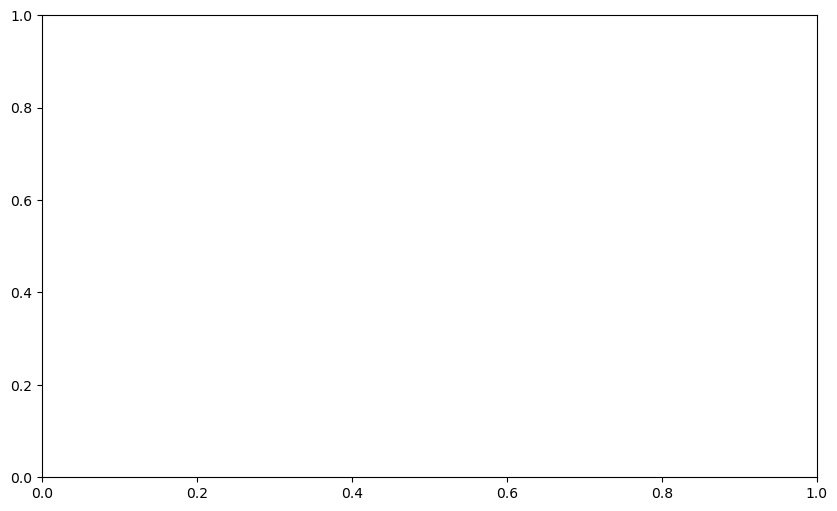

In [11]:
fig, ax = plt.subplots(figsize=(10, 6));
background_color = 'deepskyblue' # used in the circles
#ax.set_facecolor('background_color')

### Loop

Load data

In [54]:
#idx = 2
idx += 1
country, city, relative_pos = configs[idx]
region_name = f"{city}, {country}"
print(f"{idx:02d}: {region_name}")
geojson_filepath = os.path.join(data_dir, 'borders', CONFIG[country]["geojson filepath"])
raster_filepath = os.path.join(data_dir, 'rasters', CONFIG[country]["raster filepath"])
feature_ids = [prop[0] for prop in CONFIG[country]["features"][city]]
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    features = shape_data['features']
    if feature_ids:
        features_filtered = filter_features_by_list(shape_data, "shapeID", feature_ids)
        assert len(feature_ids) == len(features_filtered)
    else:
        features_filtered = features
    admin_polygons = get_polygons(features_filtered, identifier="shapeName")

07: Manila, Phillipines


Get surroundings

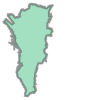

number of regions: 11
all admin polygons accounted for: True


In [55]:
border_polygon = shapely.unary_union(list(admin_polygons.values()))
display(border_polygon)
central_point = (border_polygon.centroid.x, border_polygon.centroid.y)
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    min_distance = 50e3 # metres
    # this step can be slow but it makes everything else fast:
    features = filter_features_by_proximity(shape_data, central_point, min_distance)
    #features = shape_data['features']
    region_polygons = get_polygons(features, identifier="shapeName")
print("number of regions:", len(region_polygons))
print("all admin polygons accounted for:", all(key in region_polygons for key in admin_polygons.keys()))

Raw plot

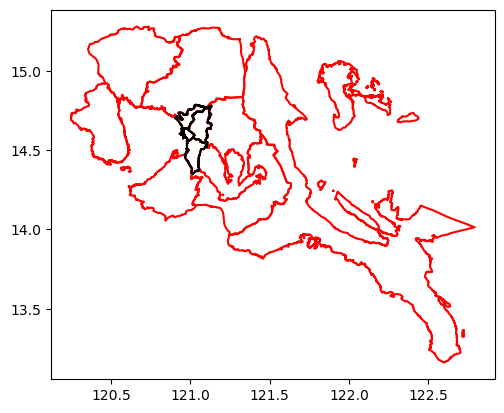

In [56]:
fig2, ax2 = plt.subplots()
plot_polygons(ax2, region_polygons.values(), 'r-')
plot_polygons(ax2, admin_polygons.values(), 'k-')
ax2.set_aspect('equal')

Scale correct and confine to circle

Manila, Phillipines: 14.57° 121.02° 1.0332


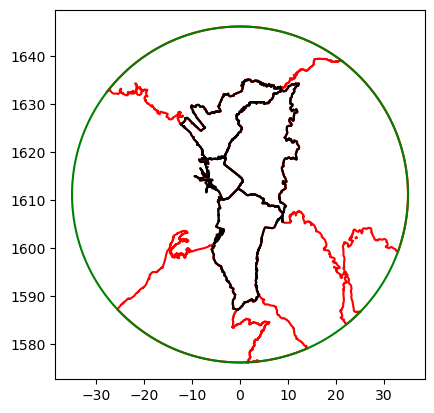

In [57]:
long_min, lat_min, long_max, lat_max = border_polygon.bounds
long_avg = (long_min + long_max) / 2
lat_avg = (lat_max + lat_min) / 2
scale = np.cos(np.deg2rad(lat_avg))
print(f'{region_name:10s}: {lat_avg:.2f}° {long_avg:.2f}° {1/scale:.4f}')

## Method 1
#corrected_polygons = scale_correction(region_polygons)
## Method 2
polygons_proj = transverse_mercator_projection(admin_polygons, long_avg)
border_polygon_proj = shapely.unary_union(list(polygons_proj.values()))
polygons_region_proj = transverse_mercator_projection(region_polygons, long_avg)

angles = np.linspace(0, 2*np.pi, 1000)
x_min, y_min, x_max, y_max = border_polygon_proj.bounds
y_mid = (y_min + y_max) / 2
x_mid = (x_min + x_max) / 2
circle = Polygon(zip(x_mid + radius * np.cos(angles), y_mid + radius * np.sin(angles)))
polygons_region_proj = {key: circle.intersection(poly) for key, poly in polygons_region_proj.items()}

fig2, ax2 = plt.subplots()
plot_polygons(ax2, polygons_region_proj.values(), 'r-')
plot_polygons(ax2, polygons_proj.values(), 'k-')
plot_polygon(ax2, circle, 'g-')
ax2.set_aspect('equal')

add to group plot

In [58]:
# fig, ax = plt.subplots(figsize=(10, 6));
# ax.set_facecolor('deepskyblue')
offset = np.array((0, -y_mid)) + relative_pos * np.pi / 180 * EARTH_RADIUS # projection already centres on average longitude

# Background circle
ax.add_patch(matplotlib.patches.Polygon(circle.exterior.coords + offset, facecolor=background_color, edgecolor='k'))

## Patches
with rasterio.open(raster_filepath) as src:
    # it would be more correct to transform this back to the src (equiangular) projection
    # That would correctly calculate the density of the cut off areas
    # But this quicker and makes the surroundings like dimmer
    polygons_raster = [region_polygons[key] for key in polygons_region_proj]
    densities, populations_counts, areas = get_density_per_area(src, polygons_raster)
print(" densities max: {:,d}".format(int(densities.max())))
patches, colors = prepare_polygon_patches(polygons_region_proj, densities, offset=offset)
p = matplotlib.collections.PatchCollection(patches, edgecolor='w', linewidth=0.4)
p.set_array(colors)
p.set_clim(0, vmax) 
axis_image = ax.add_collection(p)

# borders
plot_polygon(ax, border_polygon_proj, 'w-', offset=offset, linewidth=1.0)
plot_polygon(ax, circle, 'k-', offset=offset) # border circle

ax.autoscale()
ax.set_aspect('equal')

 densities max: 41,041


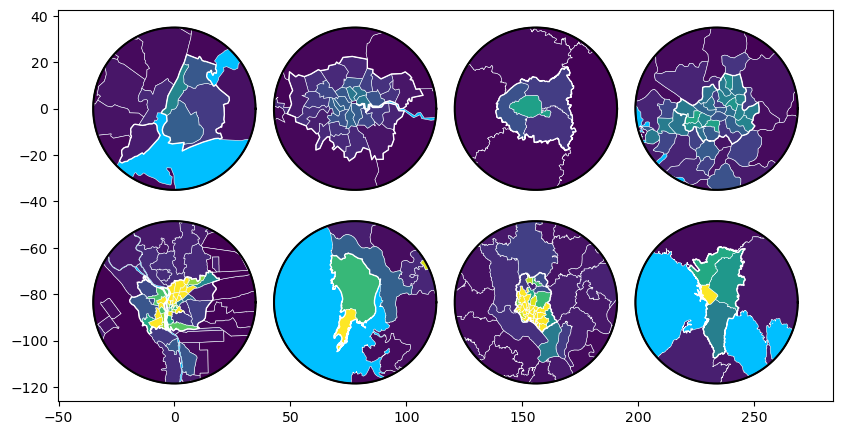

In [59]:
fig

### Units

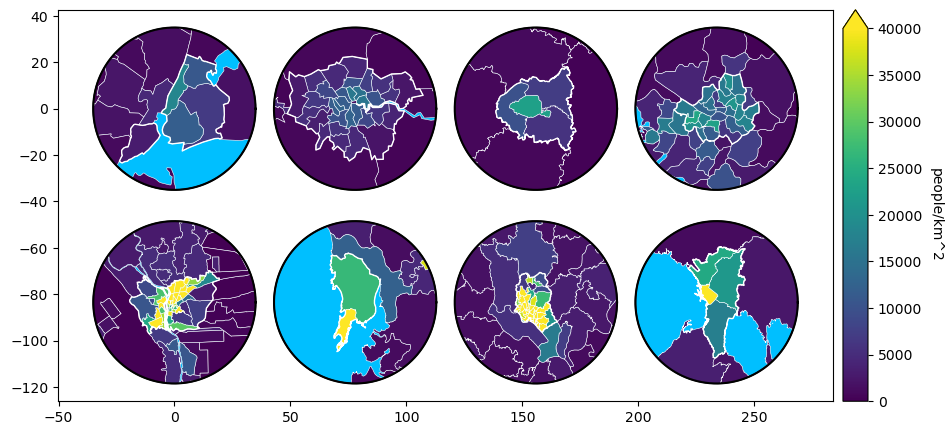

In [60]:
try:
    cbar_axis.remove()
except (NameError, KeyError):
    pass
cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(p, cbar_axis, extend='max')
cbar.set_label('people/km^2', rotation=270, labelpad=15) # counts
fig

text

In [61]:
for artist in ax.texts:
    artist.remove()
#fig

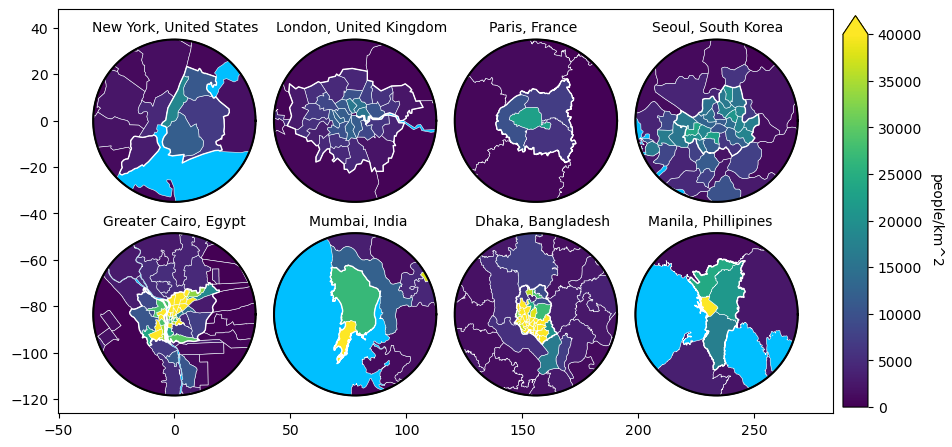

In [62]:
fig_size = fig.get_size_inches()
xlims = ax.get_xlim()
pixels_per_inch = (xlims[1] - xlims[0]) / fig_size[0]
fontsize = 10
for country, city, relative_pos in configs:
    if city == "London Boroughs":
        city = "London"
    region_name = f"{city}, {country}"
    #print(f"{region_name}")
    x_offset = pixels_per_inch * ( len(region_name)/3 * fontsize * 1/72)
    x, y = relative_pos * np.pi / 180 * EARTH_RADIUS + np.array((-x_offset, radius*1.1))
    ax.text(x, y, region_name, fontsize=fontsize)
ax.set_ylim(ymax=48)
fig

Set units if using method 1

In [ ]:
long_min, long_max = ax.get_xlim() 
lat_min, lat_max = ax.get_ylim()

width = (long_max - long_min)
height = lat_max - lat_min

EARTH_RADIUS = 6_378.137 # kilometres. At equator so use WGS-84 semi major axis
y_scale = np.pi / 180 * EARTH_RADIUS
x_scale = np.pi / 180 * EARTH_RADIUS * np.cos(0 * np.pi / 180) # at equator
y_height = (lat_max - lat_min) * y_scale # degree * rad/degree * m
x_width = (long_max - long_min) * x_scale

x_ticklabels = np.arange(0, x_width, 20)
x_ticks = x_ticklabels / x_scale + long_min
y_ticklabels = np.arange(0, y_height, 20)
y_ticks = y_ticklabels / y_scale + lat_min
x_unit = 'km'
y_unit = 'km'

ax.set_xticks(x_ticks, x_ticklabels)
ax.set_xlabel(x_unit)
ax.set_yticks(y_ticks, y_ticklabels)
ax.set_ylabel(y_unit)
ax.set_aspect('equal')
fig

Set units if using method 2

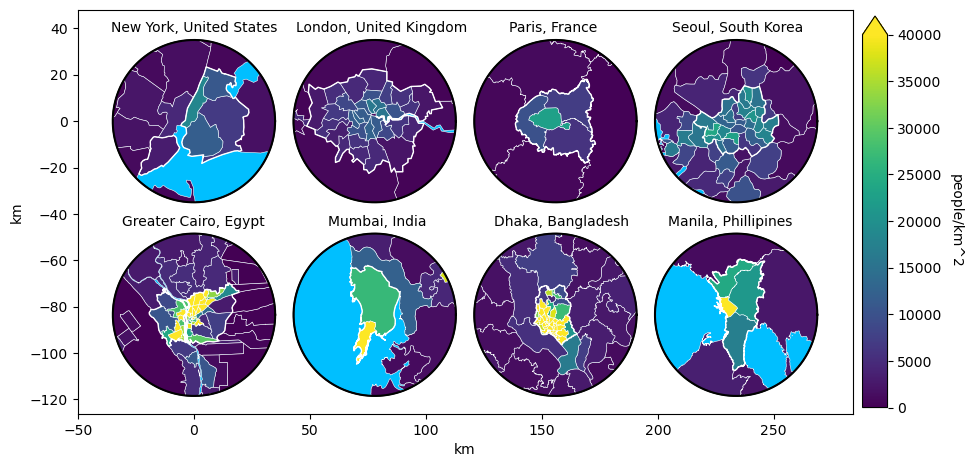

In [63]:
ax.set_xlabel('km')
ax.set_ylabel('km')
fig

remove units

In [ ]:
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
fig

switch colour map

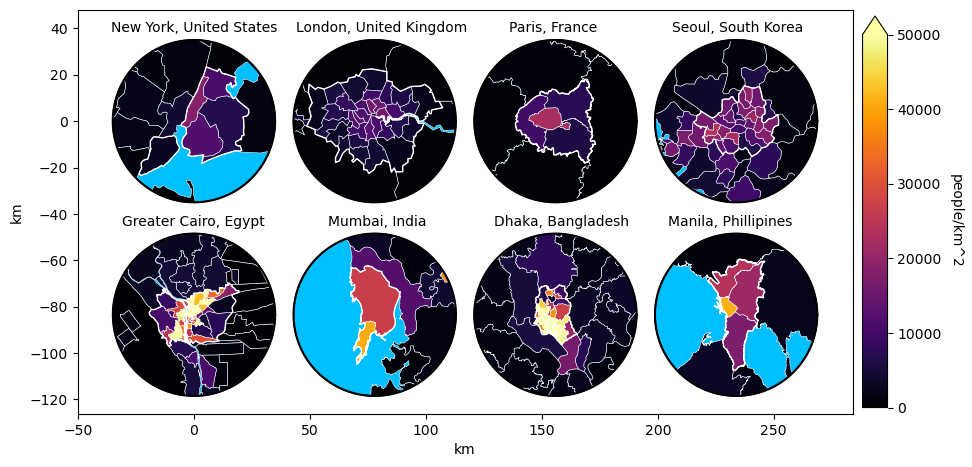

In [64]:
cmap = plt.get_cmap('inferno')
vmax = 50_000
scale = "normal"
if scale == "log":
    vmax = np.log10(vmax)
for p in ax.collections:
    p.set_cmap(cmap)
    p.set_clim(0, vmax)
fig

In [65]:
outpath = os.path.join('images', f"group_densities_{cmap.name}.png")
fig.savefig(outpath, bbox_inches="tight")
print(f"Saved figure to {outpath}")

Saved figure to images\group_densities_inferno.png
